In [1]:

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

### PREPROCESSING

In [3]:
class BostonDataset(Dataset):
    def __init__(self, X, y, to_device, scaler=StandardScaler):
        self.X = torch.tensor(X, device=to_device)
        self.y = torch.tensor(y, device=to_device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()

In [4]:
def load_data(dataset, batch_size=8, train_size=0.8, test_size=0.1, val_size=0.1):
    
    dataset_len = len(dataset)
    train_idx = int(train_size * dataset_len)
    test_idx =int(test_size * dataset_len)
    val_idx = int(val_size * dataset_len)

    train_set = Subset(dataset, np.arange(0, train_idx))
    test_set = Subset(dataset, np.arange(train_idx, train_idx + test_idx))
    val_set = Subset(dataset, np.arange(train_idx + test_idx, train_idx + test_idx + val_idx))
    
    train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return {
        'train': train_dataloader,
        'test': val_dataloader,
        'val': test_dataloader,
        'dataset': dataset
    }

In [5]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.losses = {}
        self.accuracys = {}
        self.iterations = 0
        
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.dropout(output, p=0.1)
        output = self.fc3(output)
        return output
    
    def fit(self, optimizer, loss_criterion, train_dataloader):
        self.train()
       
        self.iterations += 1
        epoch_loss = []
        
        for batch in train_dataloader:
            X, y = batch
            
            outputs = self.forward(X)
            loss = loss_criterion(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            epoch_loss.append(loss.item())
                
        self.losses[self.iterations] = np.mean(epoch_loss)
   
    def validate(self, val_dataloader, loss_criterium):
        self.eval()
        
        batch_losses = []
        with torch.no_grad():
            for batch in val_dataloader:
                X, y = batch
   
                outputs = self.forward(X)
                loss = loss_criterium(outputs, y)
                
                batch_losses.append(loss.item())
                 
            accuracy = np.mean(batch_losses)
            self.accuracys[self.iterations] = accuracy
        return accuracy
        
    def predict(self, dataloader):
        self.eval()
       
        with torch.no_grad():
            predictions = []
            for X, _ in dataloader:
                output = self.forward(X)
                predictions.extend(output)  
                      
        predictions = torch.stack(predictions)
        return predictions

In [6]:
def train_and_save(train_dataloader, val_dataloader, n_epochs, loss_criterion, opt, learning_rate, model_path=None, load_model=False):
   
    if load_model:
        model = torch.load(model_path)
    else:
        model = FNN()

    loss_criterion = loss_criterion()
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_epoch = 0
    best_accuracy = np.inf
    
    not_improving = 0
    
    for epoch in range(n_epochs):
        model.fit(optimizer=optimizer, loss_criterion=loss_criterion, train_dataloader=train_dataloader)
        accuracy = model.validate(val_dataloader=val_dataloader, loss_criterium=loss_criterion)
        
        print(f"Epoch[{epoch+1}/{n_epochs}]: Iteration: {model.iterations}, Training loss: {model.losses[model.iterations]}, Validation loss: {model.accuracys[model.iterations]}")
        
        if best_accuracy < accuracy:
            not_improving += 1
        else:
            not_improving = 0
            
        if best_accuracy > accuracy:
            best_epoch = epoch
            best_accuracy = accuracy
            torch.save(model.state_dict(), './best_regression_model.pth')
            
        if not_improving == 3:
            print(f"Val loss did not improve the last 3 epochs - Stopped at epoch : {epoch}")
            print(f"Best epoch : {best_epoch}")
            break
    
    return model

In [7]:
def plot_test_model(y_true, y_pred, title):
    data = sorted(zip(y_true, y_pred), key= lambda x: x[1])
    
    plt.figure(figsize = (15,7))
    plt.title(title)
    plt.scatter([i for i in range(len(data))], [i[0] for i in data], color="red", label="Predictions")
    plt.plot([i for i in range(len(data))],[i[1] for i in data], color='green', label="Targets", marker='o')
    plt.legend()
    plt.show()

In [8]:
def load_model(base_model, model_path):
    model = base_model()
    model.load_state_dict(torch.load(model_path))
    return model

In [9]:
# boston_df = pd.read_csv('./data/boston_train.csv')
# boston_df.drop('ID', axis=1, inplace=True)

# y = pd.DataFrame(boston_df['medv'], columns=['medv'])
# X = boston_df.drop('medv', axis=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

boston_df = pd.read_csv('./data/boston.csv', header=None, delimiter=r"\s+", names= ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'pt', 'b', 'lstat', 'medv'])

y = pd.DataFrame(boston_df['medv']).values
X = boston_df.drop('medv', axis=1).values

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

torch.manual_seed(0)

boston_set = BostonDataset(X, y, device)

dataloaders = load_data(boston_set, batch_size=8, train_size=0.8, test_size=0.1, val_size=0.1)

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

print(f'Train size : {len(train_dataloader.dataset)}')
print(f'Test size : {len(test_dataloader.dataset)}')
print(f'Val size : {len(val_dataloader.dataset)}')

loss_criterion = nn.MSELoss
optimizer = torch.optim.Adam
learning_rate = 0.0001
n_epochs = 30

model = train_and_save(train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader, 
                       n_epochs=n_epochs,
                       loss_criterion=loss_criterion,
                       opt=optimizer,
                       learning_rate=learning_rate)

Train size : 404
Test size : 50
Val size : 50
Epoch[1/30]: Iteration: 1, Training loss: 0.9908565943147621, Validation loss: 1.4204828824315752
Epoch[2/30]: Iteration: 2, Training loss: 0.9691745311606164, Validation loss: 1.3964744806289673
Epoch[3/30]: Iteration: 3, Training loss: 0.9293218293026382, Validation loss: 1.1699114867619105
Epoch[4/30]: Iteration: 4, Training loss: 0.9338243589097378, Validation loss: 1.0855651668139867
Epoch[5/30]: Iteration: 5, Training loss: 0.8676428986238498, Validation loss: 0.8724991253444127
Epoch[6/30]: Iteration: 6, Training loss: 0.8622071293054843, Validation loss: 0.8575748716081891
Epoch[7/30]: Iteration: 7, Training loss: 0.8166076124590986, Validation loss: 0.7941460609436035
Epoch[8/30]: Iteration: 8, Training loss: 0.7740514347074079, Validation loss: 0.7400324940681458
Epoch[9/30]: Iteration: 9, Training loss: 0.7311521490999296, Validation loss: 0.5876922224249158
Epoch[10/30]: Iteration: 10, Training loss: 0.7273494046108395, Validati

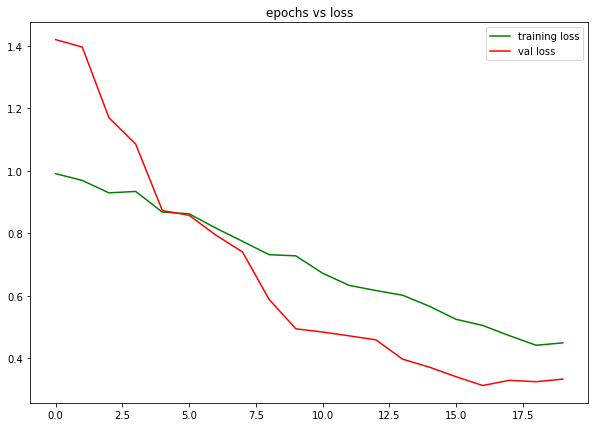

In [10]:
plt.figure(figsize = (10,7))
plt.title("epochs vs loss")
plt.plot([i for i in range(len(model.losses.values()))], list(model.losses.values()), c = 'green', label = 'training loss')
plt.plot([i for i in range(len(model.accuracys.values()))], list(model.accuracys.values()), c = 'red', label = 'val loss')
plt.legend()
plt.show()

c:\Github\applied-ai\venv\lib\site-packages\numpy\ma\core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Github\applied-ai\venv\lib\site-packages\numpy\ma\core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Github\applied-ai\venv\lib\site-packages\nump

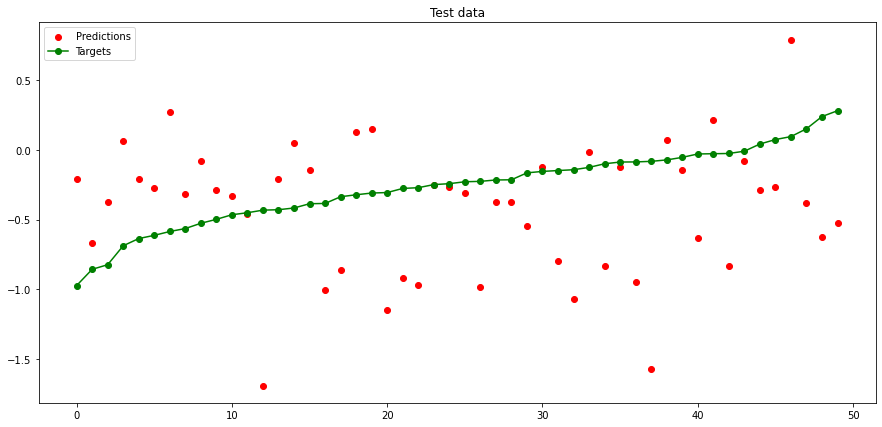

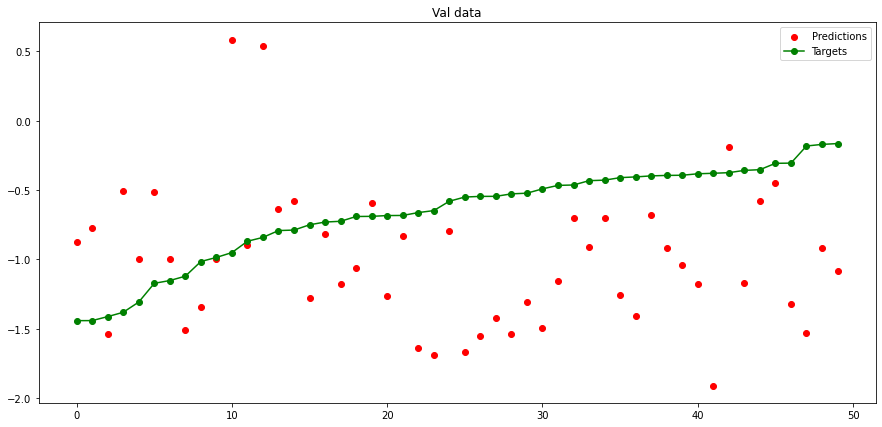

Test mse score: 0.3277085981779359
Val mse score: 0.5344522339926425


c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-ai\venv\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Github\applied-

In [11]:
best_model = load_model(FNN, 'best_regression_model.pth')

test_y_pred = best_model.predict(test_dataloader)
test_y_true = [y for _, y_batch in test_dataloader for y in y_batch]

plot_test_model(test_y_true, test_y_pred, 'Test data')

val_y_pred = best_model.predict(val_dataloader)
val_y_true = [y for _, y_batch in val_dataloader for y in y_batch]

plot_test_model(val_y_true, val_y_pred, 'Val data')

test_mse_score = mse(test_y_true, test_y_pred)
val_mse_score = mse(val_y_true, val_y_pred)

print(f"Test mse score: {test_mse_score}")
print(f"Val mse score: {val_mse_score}")